In [1]:
import os, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import io
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
from google.colab import files
import seaborn as sns

In [2]:
uploaded = files.upload()
file_path = list(uploaded.keys())[0]
data = pd.ExcelFile(file_path)

Saving Final Project_V1.xlsx to Final Project_V1.xlsx


In [3]:
df = data.parse('Sheet1')
display(df.head())

,Alpha A30P_day_1_1,Alpha A30P_day_1_2,A30P_day_1,Alpha A30P_day_10_1,Alpha A30P_day_10_2,A30P_day_10,Alpha A53T_day_1_1,Alpha A53T_day_1_2,A53T_day_1,Alpha A53T_day_10_1,...,Alpha _day_30_2,Alpha _day_30,Protein names,Gene names,Protein IDs,Unnamed: 27,GOBP name,GOMF name,GOCC name,KEGG name
0,1.13130,0.84496,0.98813,2.20060,2.54570,2.373150,1.45120,1.10010,1.275650,5.63130,...,7.35500,7.803500,Fat-body protein 1,Fbp1,Q04691-2;Q04691,NaN,establishment of localization;establishment of...,protein transporter activity;substrate-specifi...,cell part;cytoplasmic part;intracellular part;...,NaN
1,2.57750,2.04420,2.31085,2.16760,2.54700,2.357300,1.14000,0.98218,1.061090,0.86422,...,1.57050,1.607150,NaN,CG1665-RA,A1Z803,NaN,metabolic process,binding;catalytic activity;cation binding;cofa...,NaN,NaN
2,0.14459,0.13383,0.13921,0.14891,0.21182,0.180365,0.32664,0.25799,0.292315,0.13034,...,0.15222,0.164005,Laminin subunit beta-1,LanB1,P11046,NaN,anatomical structure development;basement memb...,NaN,basal lamina;extracellular matrix part;extrace...,Amoebiasis;ECM-receptor interaction;Focal adhe...
3,1.04460,4.27750,2.66105,1.18680,0.97948,1.083140,0.19248,0.45520,0.323840,1.08160,...,1.23650,1.290750,Uroporphyrinogen decarboxylase,Updo,Q9V595;B7YZR9,NaN,biosynthetic process;cellular aromatic compoun...,carbon-carbon lyase activity;carboxy-lyase act...,cell part;cytoplasm;intracellular part,Porphyrin and chlorophyll metabolism
4,1.21660,1.25430,1.23545,3.89720,3.94340,3.920300,1.88110,1.69840,1.789750,7.94980,...,8.25520,7.848750,Larval serum protein 1 gamma chain,Lsp1gamma,P11997,NaN,NaN,nutrient reservoir activity,cell part;cytoplasmic part;extracellular regio...,NaN


In [4]:
# Ensure all column names are stripped of leading/trailing spaces
df.columns = [col.strip() for col in df.columns]

# Calculate mean for WT and DM replicates
# Based on current df state, 'Alpha _day_1_1' and 'Alpha _day_1_2' would be the stripped names for WT
df['Alpha_1_days_Mean'] = df[['Alpha _day_1_1', 'Alpha _day_1_2']].mean(axis=1)

# 'Alpha A30P_day_1_1' and 'Alpha A30P_day_1_2' should be correctly identified after stripping
df['A30P_day_1_Mean'] = df[['Alpha A30P_day_1_1', 'Alpha A30P_day_1_2']].mean(axis=1)

In [5]:
# Calculate log2 fold-change
df['Log2_FC'] = np.log2(df['A30P_day_1_Mean'] / df['Alpha_1_days_Mean'].replace(0, np.nan))


In [6]:
# Perform t-tests (two-sample assuming equal variance)
t_stats, p_values = ttest_ind(
    df[['Alpha _day_1_1', 'Alpha _day_1_2']].values,
    df[['Alpha A30P_day_1_1', 'Alpha A30P_day_1_2']].values,
    axis=1, nan_policy='omit'
)

# Add p-values and -log10(p-values) to the DataFrame
df['P_Value'] = p_values
df['MinusLog10_P'] = -np.log10(df['P_Value'])

df_filtered = df[np.isfinite(df['Log2_FC']) & np.isfinite(df['MinusLog10_P'])].copy()

In [7]:
# Define significance thresholds
p_value_threshold = 0.05
log2fc_threshold = 0.58

# Filter for genes that meet both p-value and log2 fold change cutoffs
significant_downregulated = df_filtered[(df_filtered['P_Value'] < p_value_threshold) & (df_filtered['Log2_FC'] < -log2fc_threshold)]
significant_upregulated = df_filtered[(df_filtered['P_Value'] < p_value_threshold) & (df_filtered['Log2_FC'] > log2fc_threshold)]

# Select the top 5 most downregulated and top 5 most upregulated significant genes
# These are selected based on the most extreme Log2_FC values among the significant ones
top_5_downregulated = significant_downregulated.sort_values(by='Log2_FC').head(5)
top_5_upregulated = significant_upregulated.sort_values(by='Log2_FC', ascending=False).head(5)

# Concatenate these top genes for labeling and highlighting in the plot
top_genes = pd.concat([top_5_downregulated, top_5_upregulated])
print(top_genes[['Protein IDs']])

                                        Protein IDs
1512                                         P06607
1471  Q24210;E1JIS7;A8JR72;Q24210-2;A8JR71;Q24210-4
1507                                         P02843
1447                                         Q9VT23
1492                                         P02844
874                                          Q9W287
1439                                         Q8IPD8
31                                           P11996
650                                          Q9VSL8
1515                                         Q9VY87


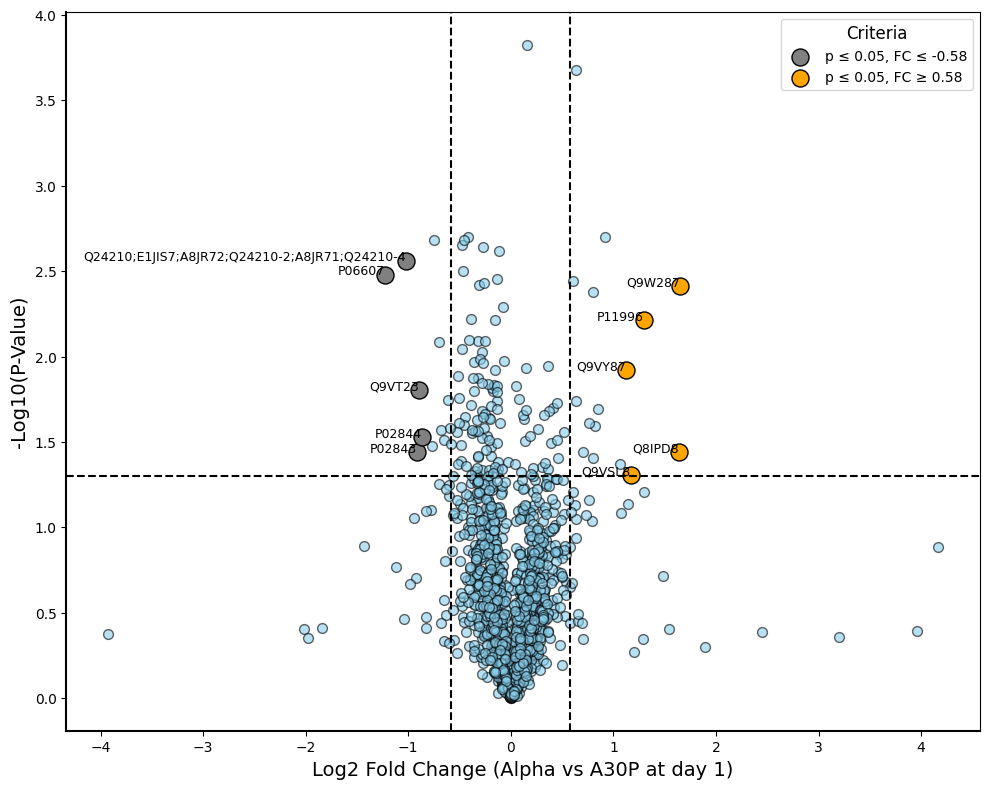

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
# Separate significant genes for coloring
left_candidates = top_genes[top_genes['Log2_FC'] < 0.58]
right_candidates = top_genes[top_genes['Log2_FC'] > -0.58]

# Create the volcano plot
plt.figure(figsize=(10, 8))
plt.scatter(df_filtered['Log2_FC'], df_filtered['MinusLog10_P'], alpha=0.6, edgecolor='black', marker='o', s=50, color='#87CEEB')
# Highlight significant genes
plt.scatter(left_candidates['Log2_FC'], left_candidates['MinusLog10_P'], color='grey', s=150, edgecolor='black', marker='o', label='p ≤ 0.05, FC ≤ -0.58')
plt.scatter(right_candidates['Log2_FC'], right_candidates['MinusLog10_P'], color='orange', s=150, edgecolor='black', marker='o', label='p ≤ 0.05, FC ≥ 0.58')

# Add gene labels
for _, row in top_genes.iterrows():
    plt.text(row['Log2_FC'], row['MinusLog10_P'], row['Protein IDs'], fontsize=9, ha='right')

# Add reference lines
plt.axhline(-np.log10(0.05), color='black', linestyle='--')
plt.axvline(0.58, color='black', linestyle='--')
plt.axvline(-0.58, color='black', linestyle='--')

# Add a border
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

# Update axis labels and add legend
plt.xlabel('Log2 Fold Change (Alpha vs A30P at day 1)', fontsize=14)
plt.ylabel('-Log10(P-Value)', fontsize=14)
plt.legend(loc='best', fontsize=10, title='Criteria', title_fontsize=12)
# Save the plot as PNG (600 DPI) and PDF
png_path = 'volcano_plot1.png'
pdf_path = 'volcano_plot1.pdf'
plt.savefig(png_path, dpi=600, format='png')
plt.savefig(pdf_path, format='pdf')
plt.tight_layout()
# Show the plot
plt.show()
# Download the files
files.download(png_path)
files.download(pdf_path)
CSV_path = 'filtered_data.csv'
df_filtered.to_csv(CSV_path, index=False)
from google.colab import files
files.download(CSV_path)